In [1]:
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio as io
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torchmetrics
import pytorch_lightning as pl

import data_loader as dl
import experiments as e


!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
class_names = ['Abstract_Expressionism','Baroque','Cubism', 'Fauvism', 'Impressionism','Minimalism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']
device = 'cpu'

num_classes = 10


Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
Source files will be saved in "/tmp/tmpy9_n4u44".


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np
with open('X_mb_5 (1).pickle', 'rb') as handle:
    train_data = pickle.load(handle)
with open('Y_mb_5.pickle', 'rb') as handle:
    train_labels = pickle.load(handle)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {np.shape(X_train)}, Test: {np.shape(X_test)}")
print(f"Train: {np.shape(train_data)}, Test: {np.shape(train_labels)}")

Train: (14804, 139), Test: (3701, 139)
Train: (18505, 139), Test: (18505,)


In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import  numpy as np
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import time
import psutil
import pandas as pd
from sklearn.metrics import  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
)
def precision_recall_draw(y_true, y_score):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import precision_recall_curve

    y_test_bin = label_binarize(y_true, classes=[i for i in range(len(class_names))])

    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, lw=2, label=f'{class_name}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


def roc_draw(y_true, y_score):
  from sklearn.preprocessing import label_binarize
  plt.figure(figsize=(15, 10))
  y_test_bin = label_binarize(y_true, classes=[i for i in range(len(class_names))])


  for i, class_name in enumerate(class_names):
     fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
     roc_auc = auc(fpr, tpr)
     plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')


  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend(loc="best")
  plt.grid(True)
  plt.show()


def evaluate_model(y_true, y_pred, y_pred_proba):
    report_dict = classification_report(y_pred, y_true, target_names=class_names, output_dict=True)
    metrics_df2 = pd.DataFrame(report_dict).transpose()
    print(metrics_df2)
    print("-----------------------------------------------------------------------------------------------------------")

    precision_recall_draw(y_true, y_pred_proba)
    roc_draw(y_true, y_pred_proba)
    cm =confusion_matrix(y_true, y_pred, normalize = 'true')
    #cm_percent_row = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    
    disp = ConfusionMatrixDisplay(cm*100, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap="cividis", ax=ax) 
    for _, spine in ax.spines.items():
        spine.set_visible(False)  

    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.grid(False) 
    plt.title("Confusion Matrix")
    #plt.colorbar(ax.collections[0], ax=ax)  
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap="cividis", ax=ax) 
    for _, spine in ax.spines.items():
        spine.set_visible(False)  

    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.grid(False) 
    plt.title("Not normalized Confusion Matrix")
    plt.show()

                        precision    recall  f1-score      support
Abstract_Expressionism   0.818487  0.799672  0.808970   609.000000
Baroque                  0.868373  0.768608  0.815451   618.000000
Cubism                   0.753056  0.793814  0.772898   388.000000
Fauvism                  0.664740  0.845588  0.744337   136.000000
Impressionism            0.902397  0.792481  0.843875   665.000000
Minimalism               0.878173  0.891753  0.884910   194.000000
Naive_Art_Primitivism    0.766667  0.841463  0.802326   410.000000
Pointillism              0.807692  0.823529  0.815534   102.000000
Rococo                   0.716080  0.882353  0.790569   323.000000
Ukiyo_e                  0.881148  0.839844  0.860000   256.000000
accuracy                 0.814374  0.814374  0.814374     0.814374
macro avg                0.805681  0.827911  0.813887  3701.000000
weighted avg             0.821872  0.814374  0.815517  3701.000000
--------------------------------------------------------------

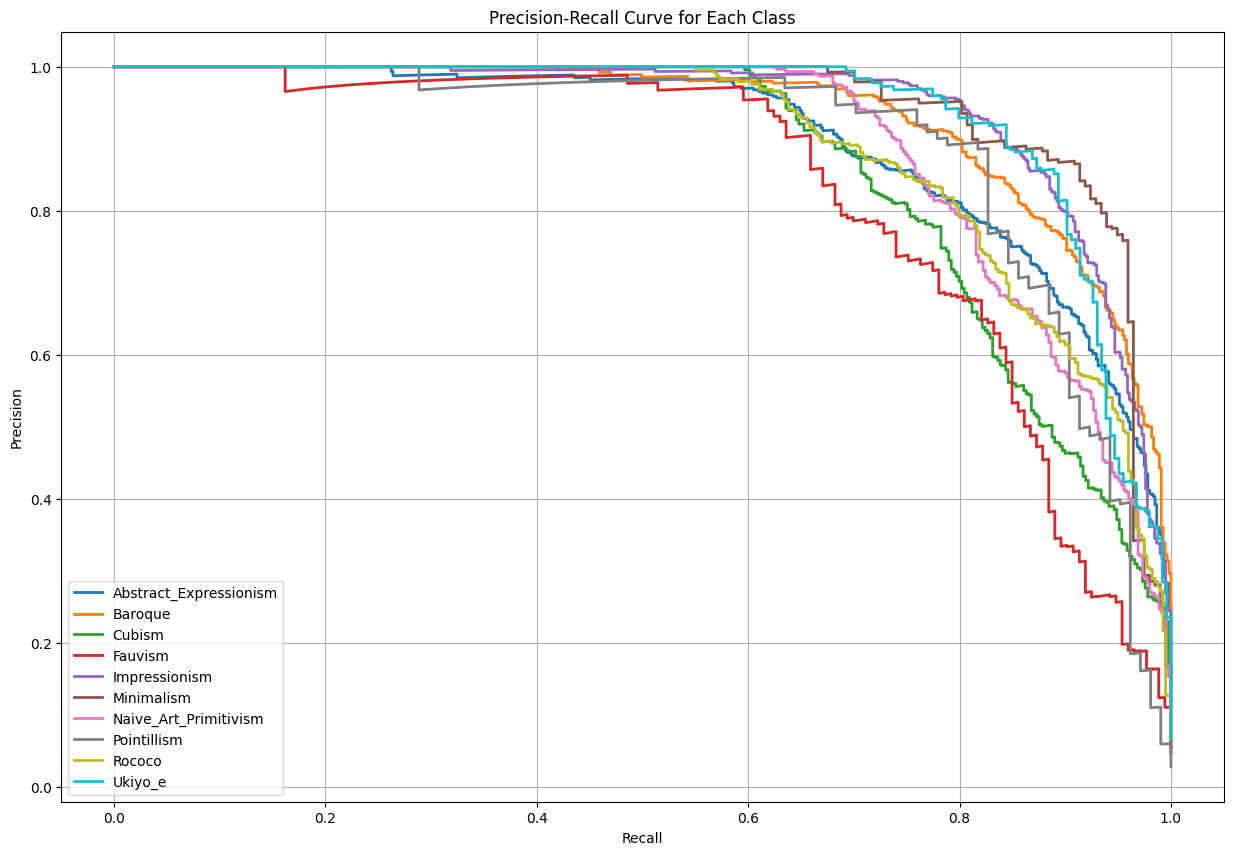

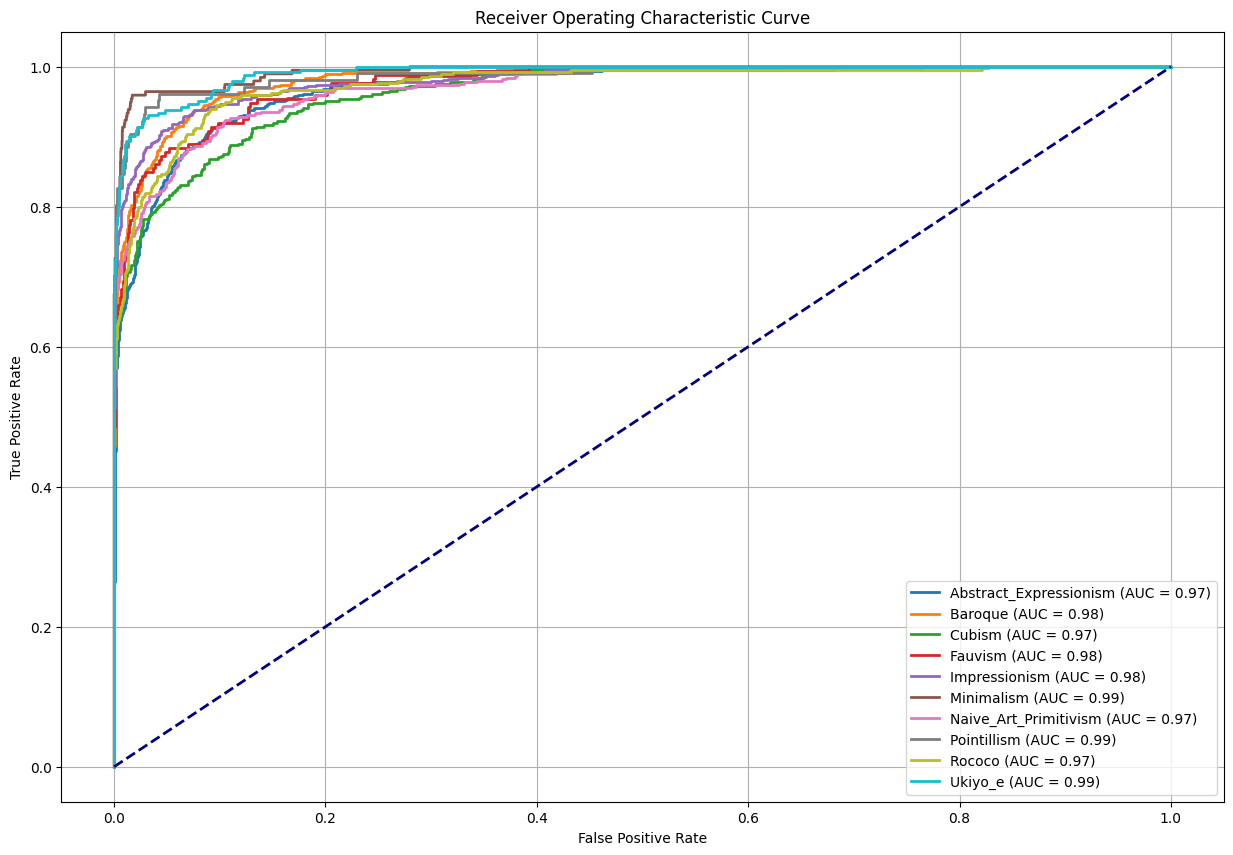

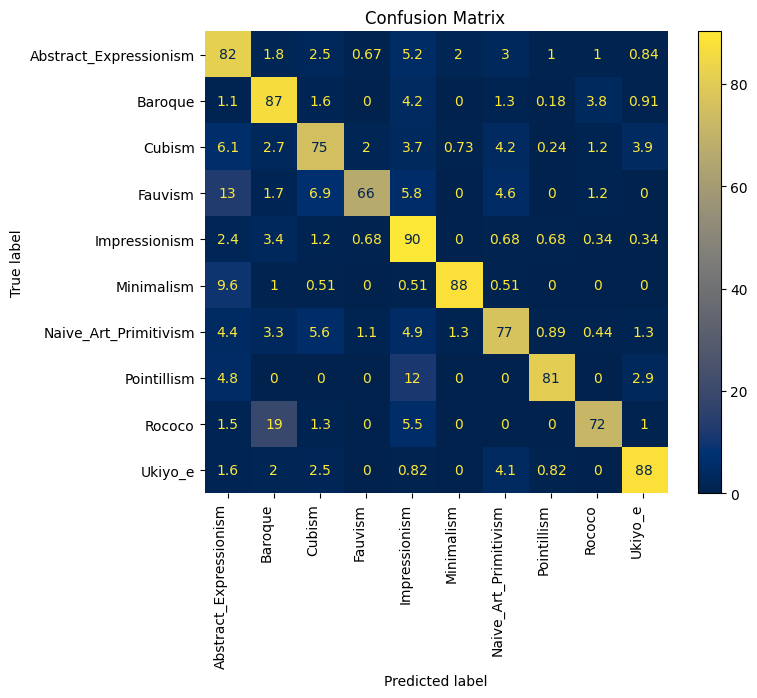

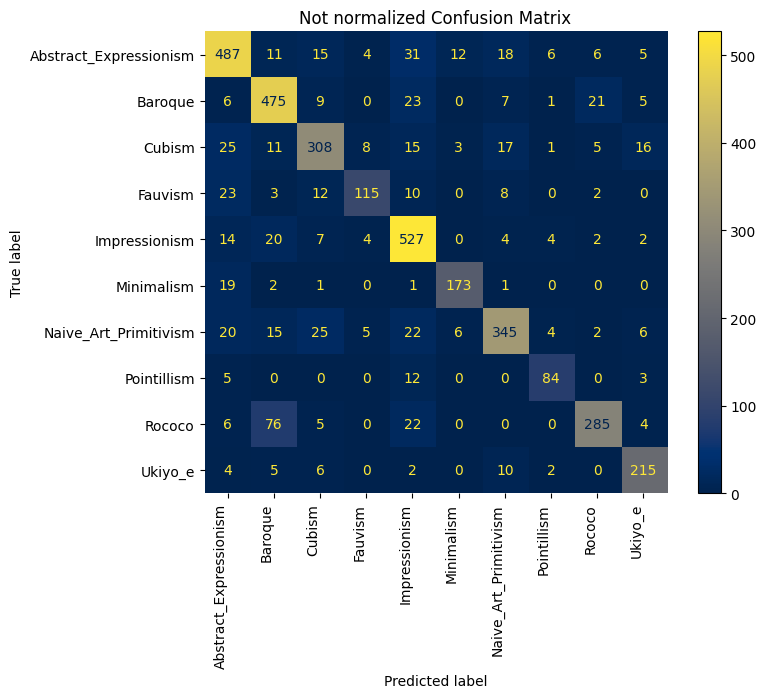

In [5]:
from sklearn.ensemble import RandomForestClassifier
best_params = {
    'n_estimators': 1100,
    'max_depth': 40,
    'min_samples_split': 8,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'bootstrap': False,
    'criterion': 'entropy'
}

model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train_scaled, y_train)
frmodel_pred = model.predict(X_test_scaled)
frmodel_pred_proba = model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)


In [6]:
best_params = {
    'n_estimators': 1100,
    'max_depth': 40,
    'min_samples_split': 8,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'bootstrap': False,
    'criterion': 'entropy'
}

model = RandomForestClassifier(**best_params, random_state=42)
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy   Train time  \
0         1   0.811508  0.807890  0.807056  0.807890  2094.268832   
1         2   0.810722  0.808160  0.807321  0.808160  2060.801709   
2         3   0.817765  0.814374  0.813584  0.814374  2092.000413   
3         4   0.803200  0.799784  0.798321  0.799784  2066.308460   
4         5   0.808073  0.803567  0.802363  0.803567  2111.494139   
5   Average   0.810254  0.806755  0.805729  0.806755  2084.974711   
6  1.581139   0.005308  0.005479  0.005749  0.005479    21.046284   

   Prediction time  
0         5.393531  
1         6.393312  
2         5.795536  
3         4.897728  
4         5.894845  
5         5.674990  
6         0.561741  


                        precision    recall  f1-score      support
Abstract_Expressionism   0.815126  0.789902  0.802316   614.000000
Baroque                  0.868373  0.792988  0.828970   599.000000
Cubism                   0.733496  0.800000  0.765306   375.000000
Fauvism                  0.716763  0.810458  0.760736   153.000000
Impressionism            0.890411  0.806202  0.846216   645.000000
Minimalism               0.908629  0.881773  0.895000   203.000000
Naive_Art_Primitivism    0.773333  0.816901  0.794521   426.000000
Pointillism              0.836538  0.820755  0.828571   106.000000
Rococo                   0.743719  0.853026  0.794631   347.000000
Ukiyo_e                  0.872951  0.914163  0.893082   233.000000
accuracy                 0.817887  0.817887  0.817887     0.817887
macro avg                0.815934  0.828617  0.820935  3701.000000
weighted avg             0.822404  0.817887  0.818744  3701.000000
--------------------------------------------------------------

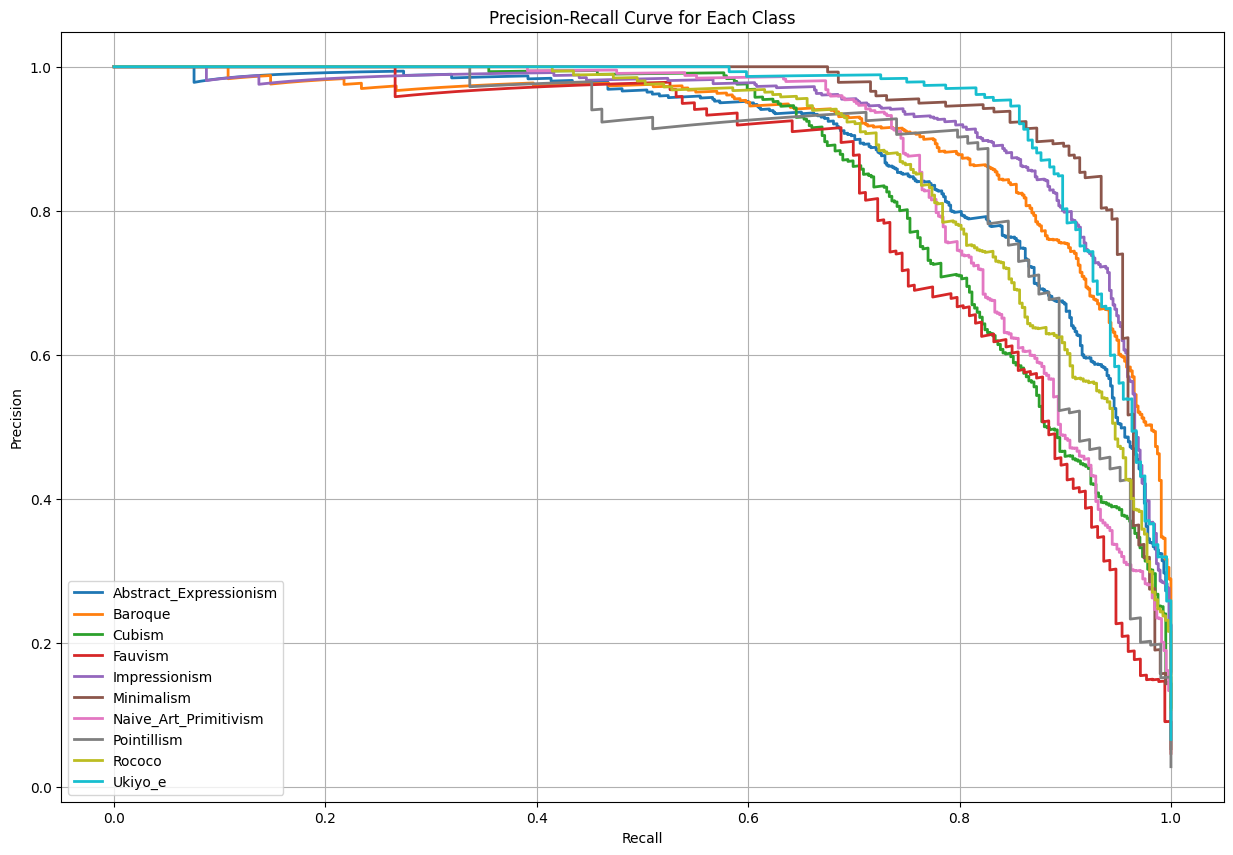

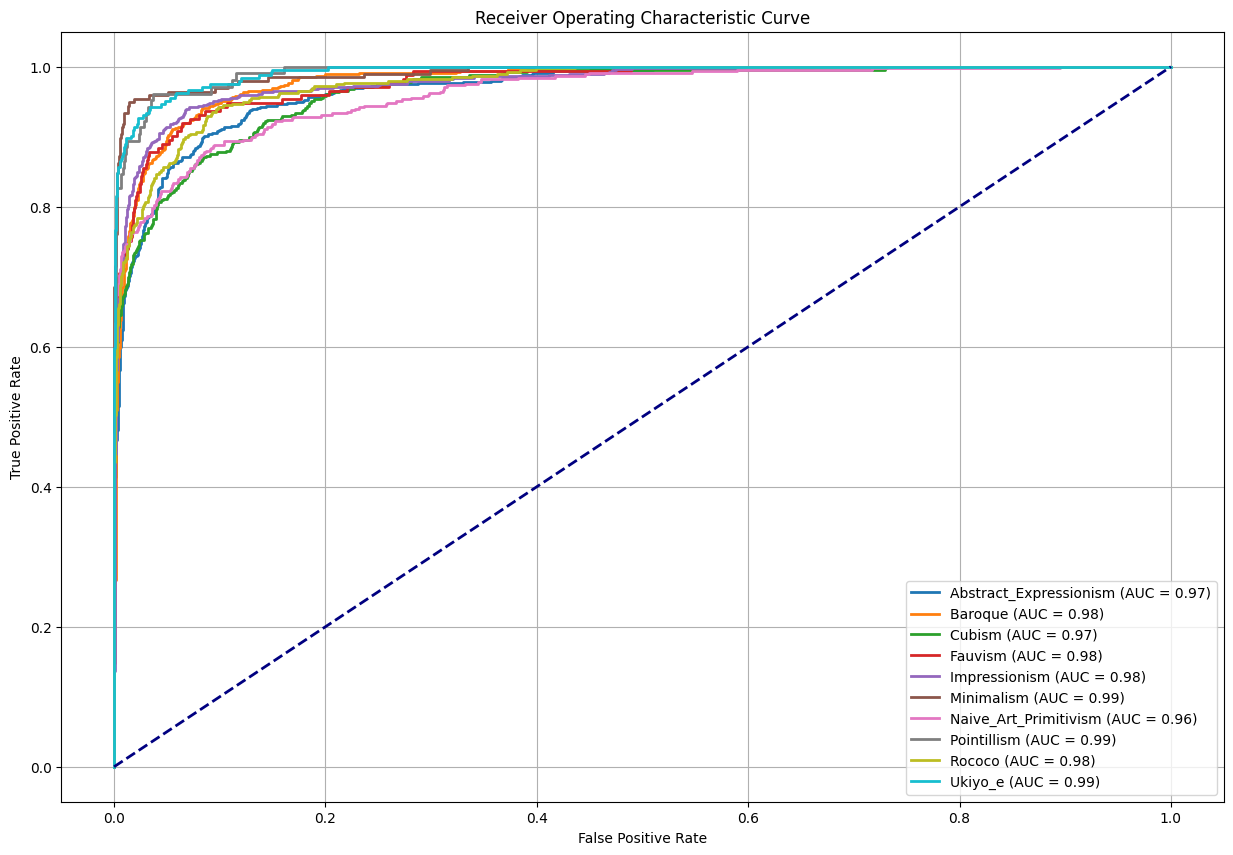

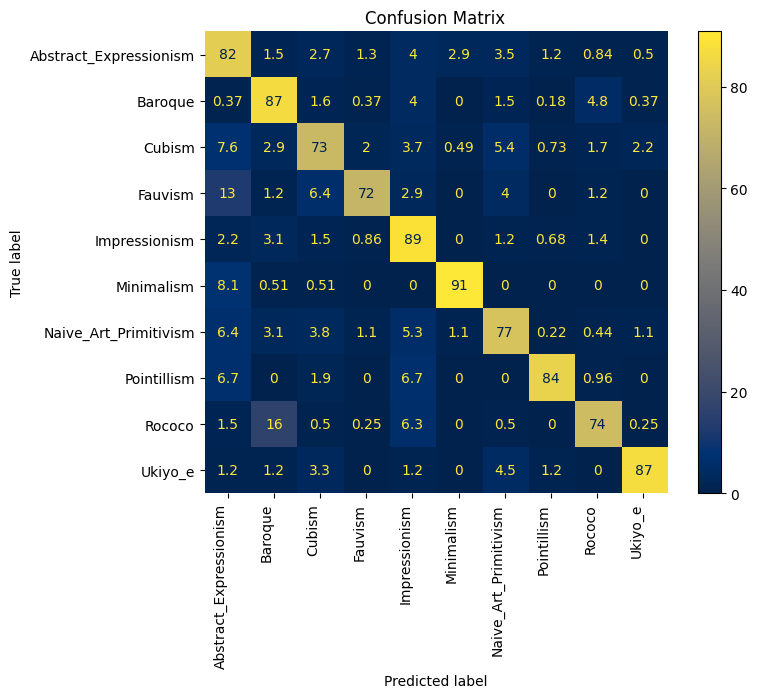

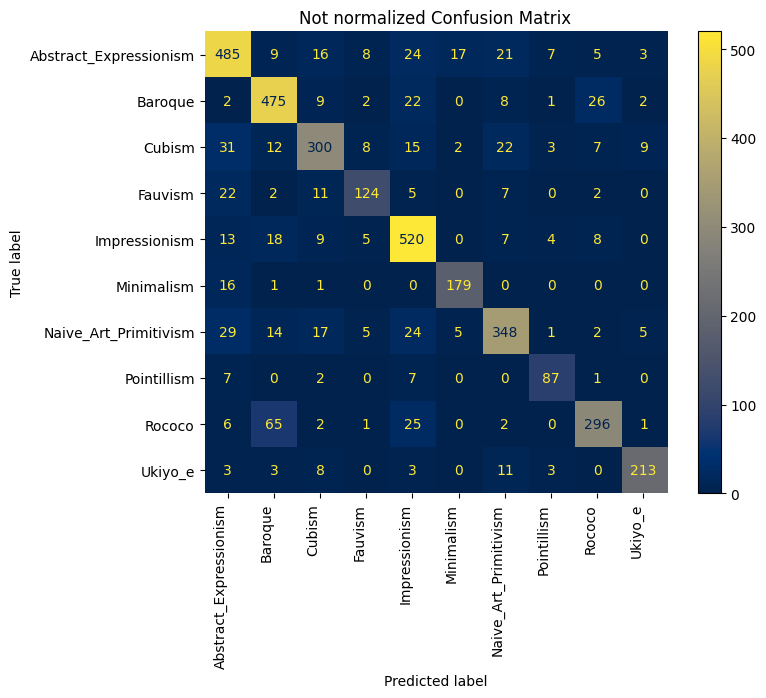

In [6]:
from xgboost import XGBClassifier

# Best parameters from tuning
best_params = {
    'n_estimators': 900,
    'max_depth': 43,
    'learning_rate': 0.08634024748658073,
    'subsample': 0.6459348663757389,
    'colsample_bytree': 0.6097240940126756,
    'gamma': 0.010734217856306127,
    'reg_lambda': 0.14047299523258086,
    'reg_alpha':  0.013608078355981755
}

model = XGBClassifier(
    **best_params
)

model.fit(X_train_scaled, y_train)
frmodel_pred = model.predict(X_test_scaled)
frmodel_pred_proba = model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)


In [7]:
best_params = {
    'n_estimators': 900,
    'max_depth': 43,
    'learning_rate': 0.08634024748658073,
    'subsample': 0.6459348663757389,
    'colsample_bytree': 0.6097240940126756,
    'gamma': 0.010734217856306127,
    'reg_lambda': 0.14047299523258086,
    'reg_alpha':  0.013608078355981755
}

model = XGBClassifier(
    **best_params
)

avg= e.kfold_crossvalidation(train_data, train_labels, 5,  model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.812638  0.811402  0.810692  0.811402   57.962458   
1         2   0.820423  0.819238  0.818046  0.819238   57.977210   
2         3   0.815487  0.814645  0.813847  0.814645   57.953374   
3         4   0.805849  0.806269  0.804823  0.806269   57.587409   
4         5   0.816235  0.815455  0.814544  0.815455   57.790900   
5   Average   0.814126  0.813402  0.812390  0.813402   57.854270   
6  1.581139   0.005401  0.004866  0.004972  0.004866    0.167236   

   Prediction time  
0         0.021081  
1         0.022290  
2         0.022329  
3         0.022028  
4         0.022236  
5         0.021993  
6         0.000523  


                        precision    recall  f1-score    support
Abstract_Expressionism   0.657143  0.807851  0.724745   484.0000
Baroque                  0.760512  0.661367  0.707483   629.0000
Cubism                   0.640587  0.717808  0.677003   365.0000
Fauvism                  0.572254  0.556180  0.564103   178.0000
Impressionism            0.794521  0.694611  0.741214   668.0000
Minimalism               0.822335  0.880435  0.850394   184.0000
Naive_Art_Primitivism    0.693333  0.718894  0.705882   434.0000
Pointillism              0.759615  0.675214  0.714932   117.0000
Rococo                   0.678392  0.635294  0.656136   425.0000
Ukiyo_e                  0.733607  0.824885  0.776573   217.0000
accuracy                 0.711700  0.711700  0.711700     0.7117
macro avg                0.711230  0.717254  0.711846  3701.0000
weighted avg             0.716410  0.711700  0.711234  3701.0000
------------------------------------------------------------------------------------------

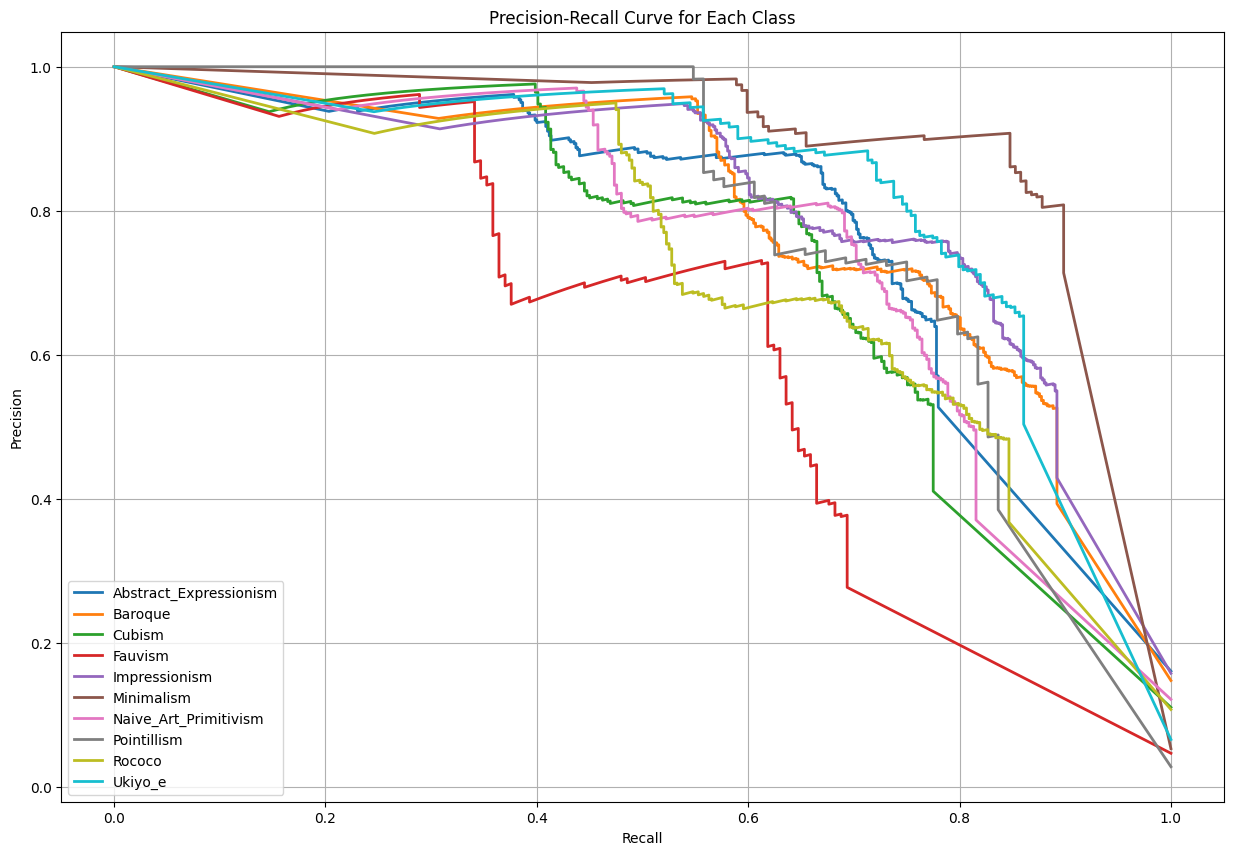

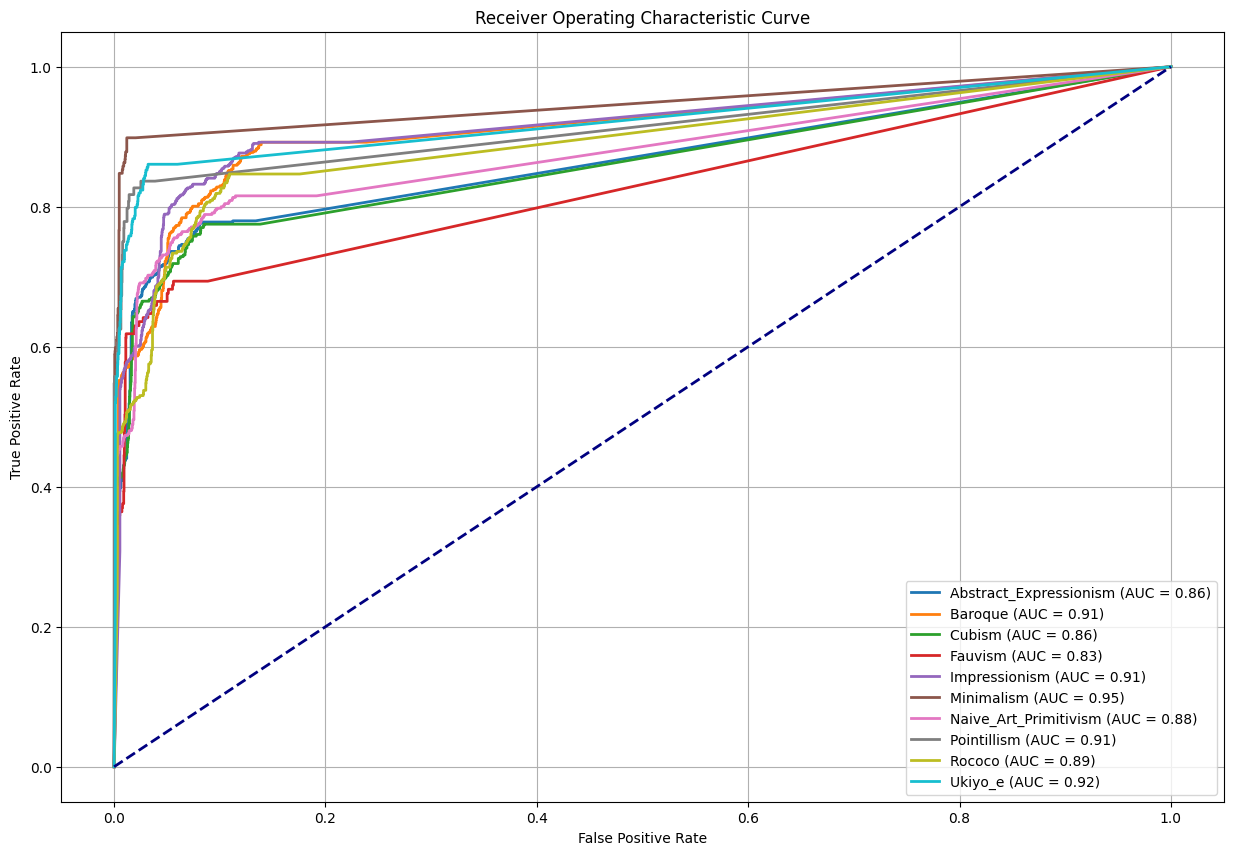

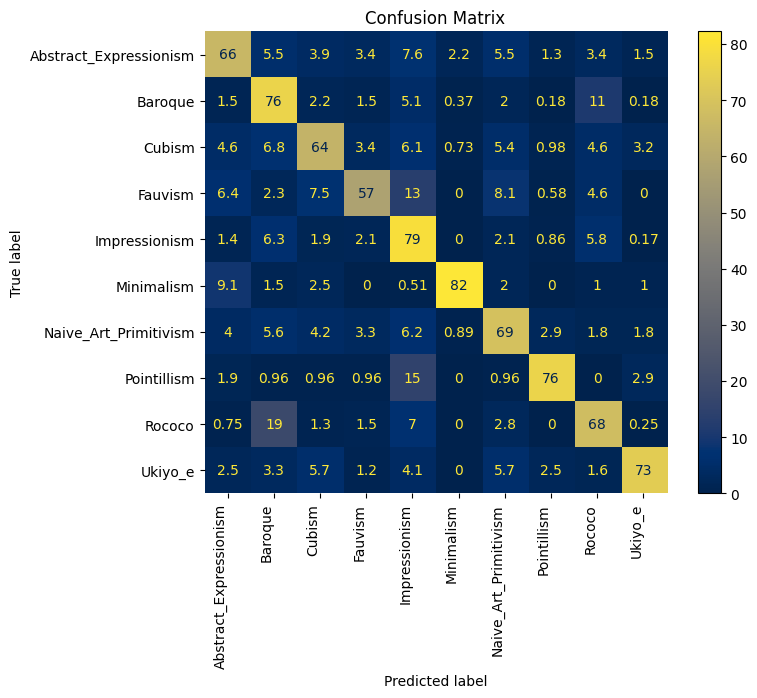

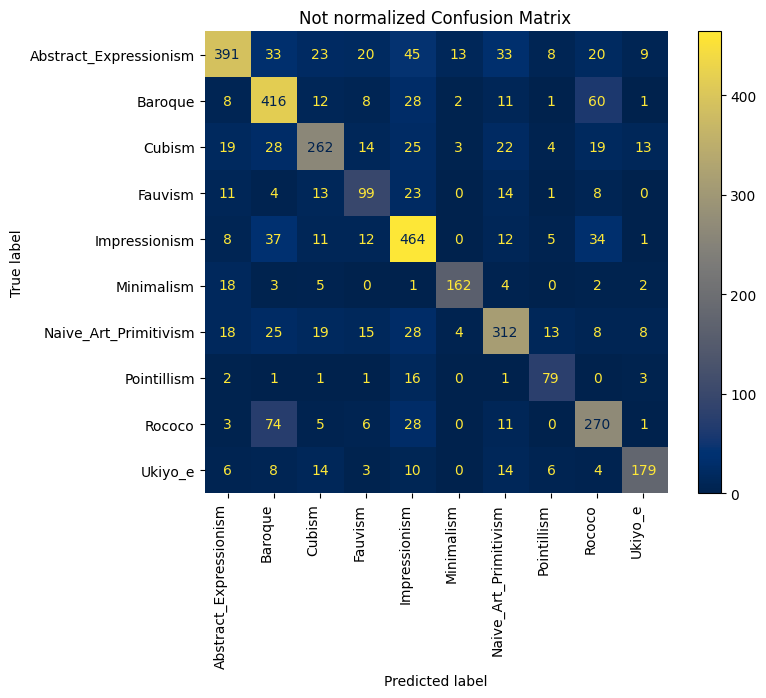

In [8]:
from sklearn.neighbors import KNeighborsClassifier
best_params = {
    'metric': 'manhattan',
    'algorithm': 'auto',
    'n_neighbors': 3,
    'weights': 'distance',
    'leaf_size': 30,
    'p': 1
}
model = KNeighborsClassifier(
    **best_params
)
model.fit(X_train_scaled, y_train)
frmodel_pred = model.predict(X_test_scaled)
frmodel_pred_proba = model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)


In [9]:
best_params = {
    'metric': 'manhattan',
    'algorithm': 'auto',
    'n_neighbors': 3,
    'weights': 'distance',
    'leaf_size': 30,
    'p': 2
}
model = KNeighborsClassifier(
    **best_params
)
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.725086  0.719535  0.719586  0.719535    0.003793   
1         2   0.721470  0.717644  0.717758  0.717644    0.004184   
2         3   0.716233  0.710349  0.710535  0.710349    0.006263   
3         4   0.704592  0.700892  0.700387  0.700892    0.006058   
4         5   0.712092  0.707106  0.707441  0.707106    0.005911   
5   Average   0.715895  0.711105  0.711141  0.711105    0.005242   
6  1.581139   0.008030  0.007660  0.007823  0.007660    0.001159   

   Prediction time  
0         0.125195  
1         0.137698  
2         0.123439  
3         0.128831  
4         0.126192  
5         0.128271  
6         0.005619  


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np
with open('X_mobilenet_v3_b11 (1).pickle', 'rb') as handle:
    train_data = pickle.load(handle)
with open('Y_mobilenet_v3_b11 (1).pickle', 'rb') as handle:
    train_labels = pickle.load(handle)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {np.shape(X_train)}, Test: {np.shape(X_test)}")
print(f"Train: {np.shape(train_data)}, Test: {np.shape(train_labels)}")

Train: (14804, 211), Test: (3701, 211)
Train: (18505, 211), Test: (18505,)


/venv/main/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


                        precision    recall  f1-score      support
Abstract_Expressionism   0.808436  0.793103  0.800696   580.000000
Baroque                  0.866788  0.785124  0.823938   605.000000
Cubism                   0.773585  0.773585  0.773585   424.000000
Fauvism                  0.625000  0.851852  0.721003   135.000000
Impressionism            0.895307  0.763077  0.823920   650.000000
Minimalism               0.906103  0.873303  0.889401   221.000000
Naive_Art_Primitivism    0.746204  0.828916  0.785388   415.000000
Pointillism              0.725275  0.846154  0.781065    78.000000
Rococo                   0.703349  0.864706  0.775726   340.000000
Ukiyo_e                  0.874477  0.826087  0.849593   253.000000
accuracy                 0.805188  0.805188  0.805188     0.805188
macro avg                0.792452  0.820591  0.802432  3701.000000
weighted avg             0.814510  0.805188  0.806777  3701.000000
--------------------------------------------------------------

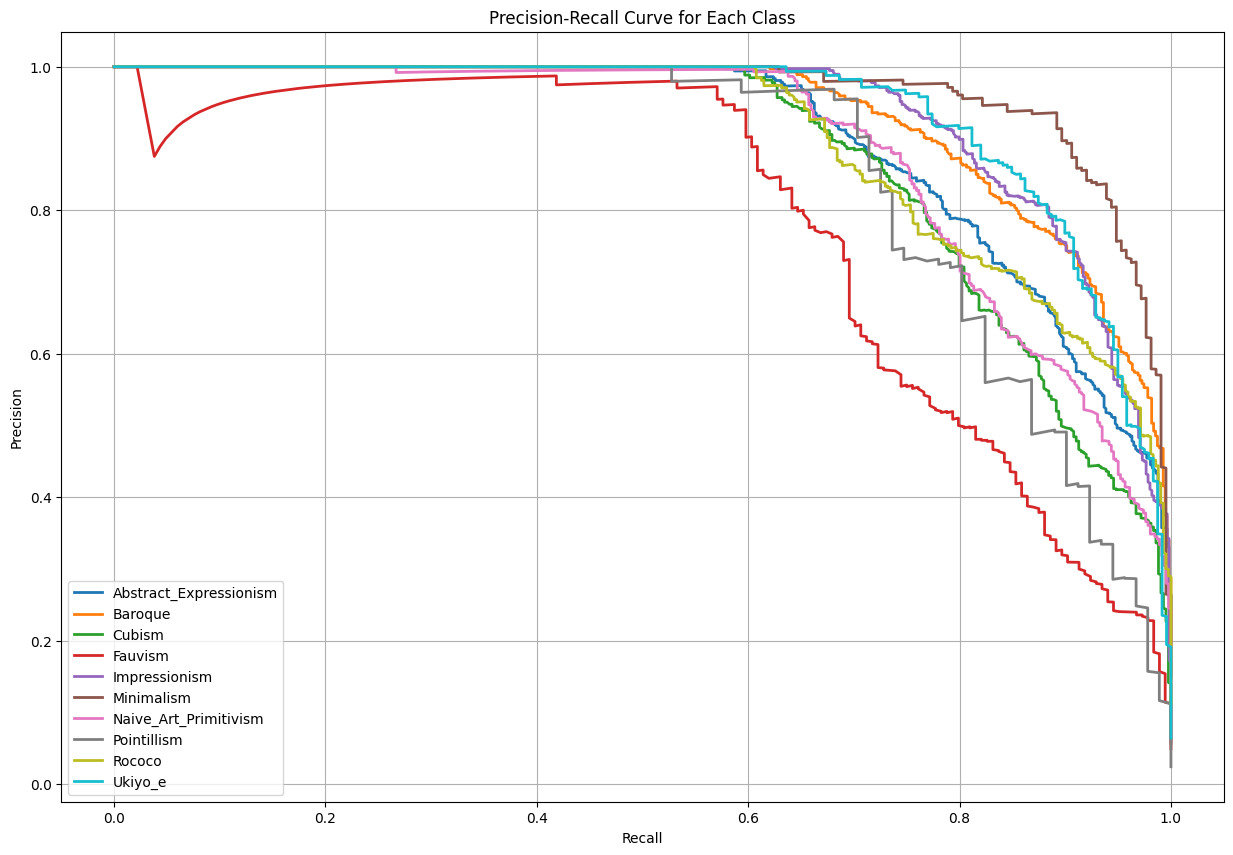

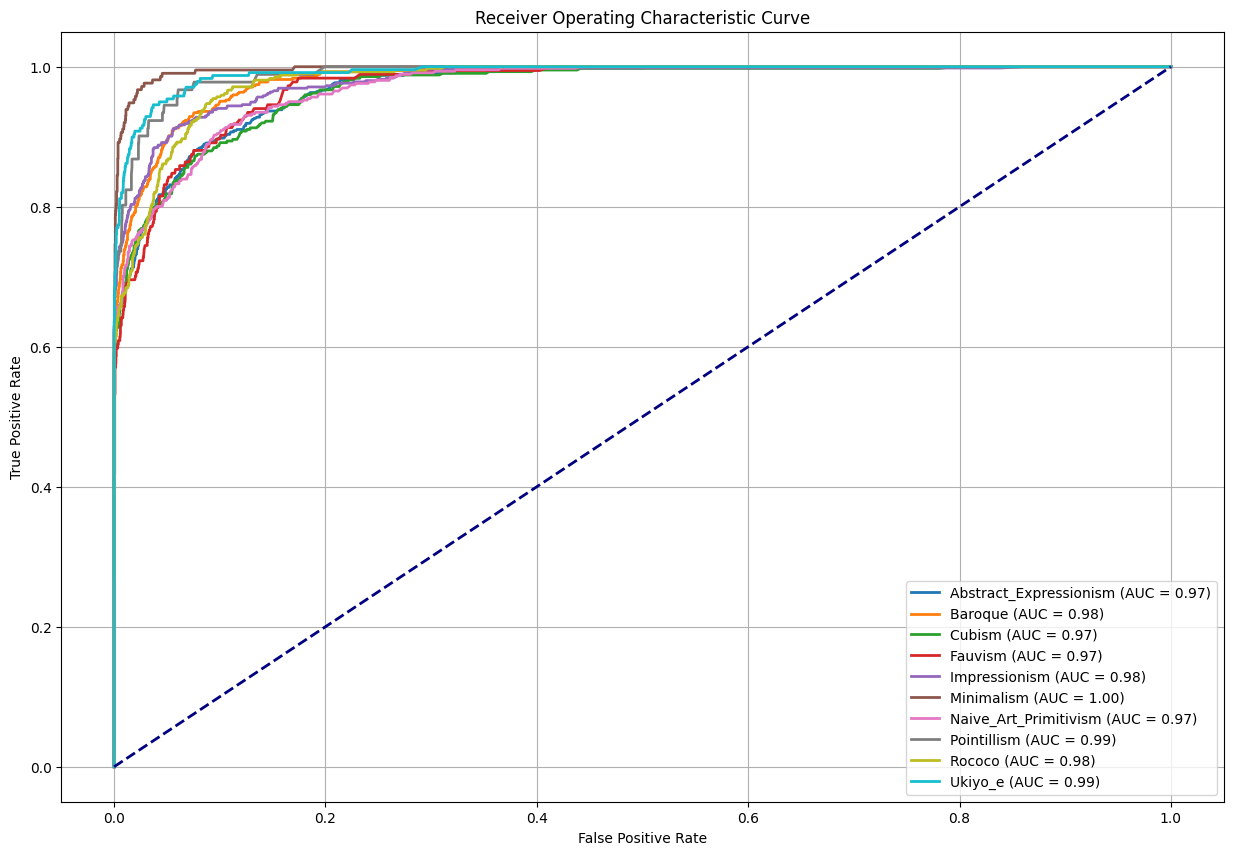

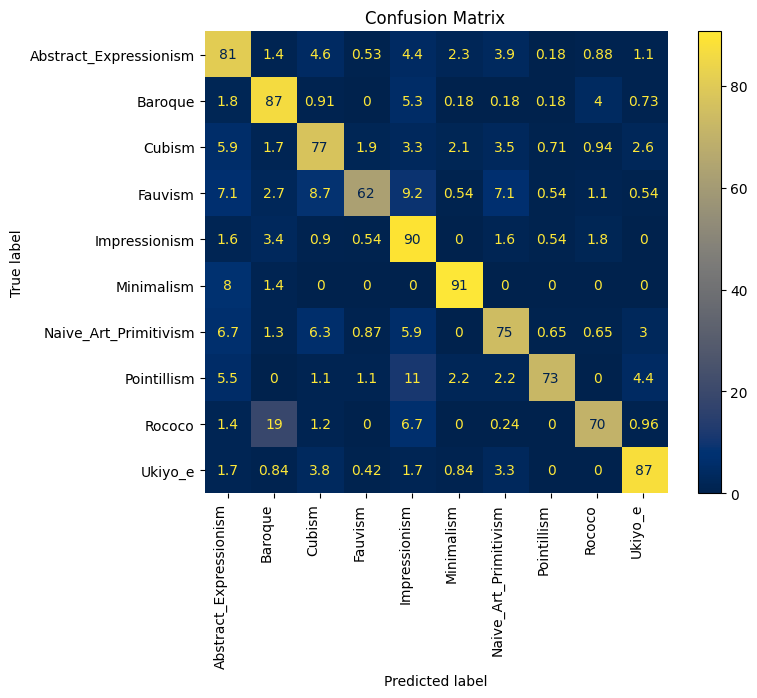

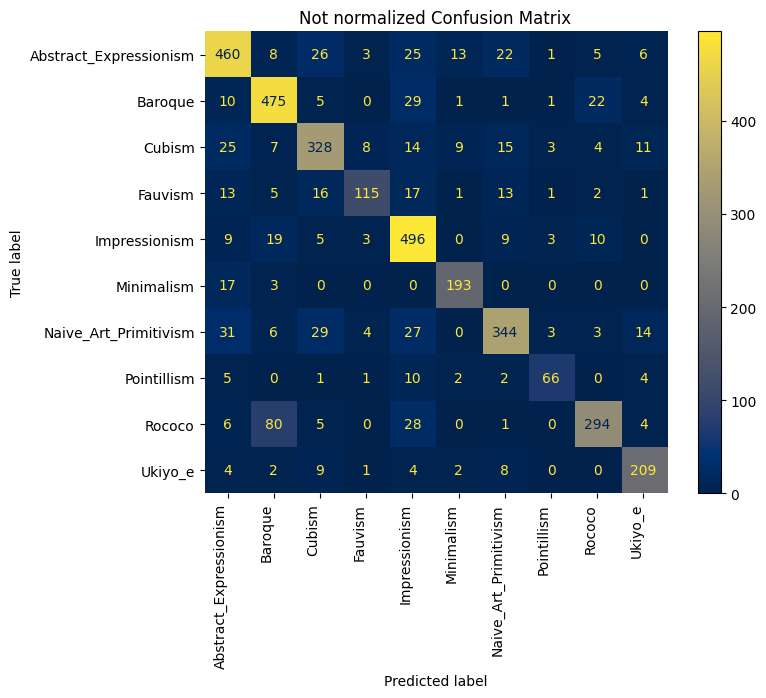

In [11]:
best_params = {
    'n_estimators': 1000,
    'max_depth': 50,
    'min_samples_split': 3,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'bootstrap': False,
    'criterion': 'entropy'
}
model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train_scaled, y_train)
frmodel_pred = model.predict(X_test_scaled)
frmodel_pred_proba = model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)


In [12]:
best_params = {
    'n_estimators': 1000,
    'max_depth': 50,
    'min_samples_split': 3,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'bootstrap': False,
    'criterion': 'entropy'
}
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.807010  0.804918  0.804181  0.804918  326.031914   
1         2   0.807071  0.804377  0.803688  0.804377  326.243117   
2         3   0.812290  0.808430  0.807348  0.808430  326.157057   
3         4   0.807962  0.804107  0.802885  0.804107  326.097357   
4         5   0.813379  0.809781  0.809241  0.809781  327.357491   
5   Average   0.809542  0.806323  0.805469  0.806323  326.377387   
6  1.581139   0.003053  0.002601  0.002705  0.002601    0.553386   

   Prediction time  
0         0.672914  
1         0.671522  
2         0.674381  
3         0.671558  
4         0.670714  
5         0.672218  
6         0.001444  


                        precision    recall  f1-score      support
Abstract_Expressionism   0.796134  0.797535  0.796834   568.000000
Baroque                  0.886861  0.811352  0.847428   599.000000
Cubism                   0.787736  0.780374  0.784038   428.000000
Fauvism                  0.652174  0.794702  0.716418   151.000000
Impressionism            0.879061  0.784219  0.828936   621.000000
Minimalism               0.910798  0.885845  0.898148   219.000000
Naive_Art_Primitivism    0.772234  0.809091  0.790233   440.000000
Pointillism              0.736264  0.807229  0.770115    83.000000
Rococo                   0.724880  0.865714  0.789062   350.000000
Ukiyo_e                  0.887029  0.876033  0.881497   242.000000
accuracy                 0.813834  0.813834  0.813834     0.813834
macro avg                0.803317  0.821209  0.810271  3701.000000
weighted avg             0.819694  0.813834  0.815060  3701.000000
--------------------------------------------------------------

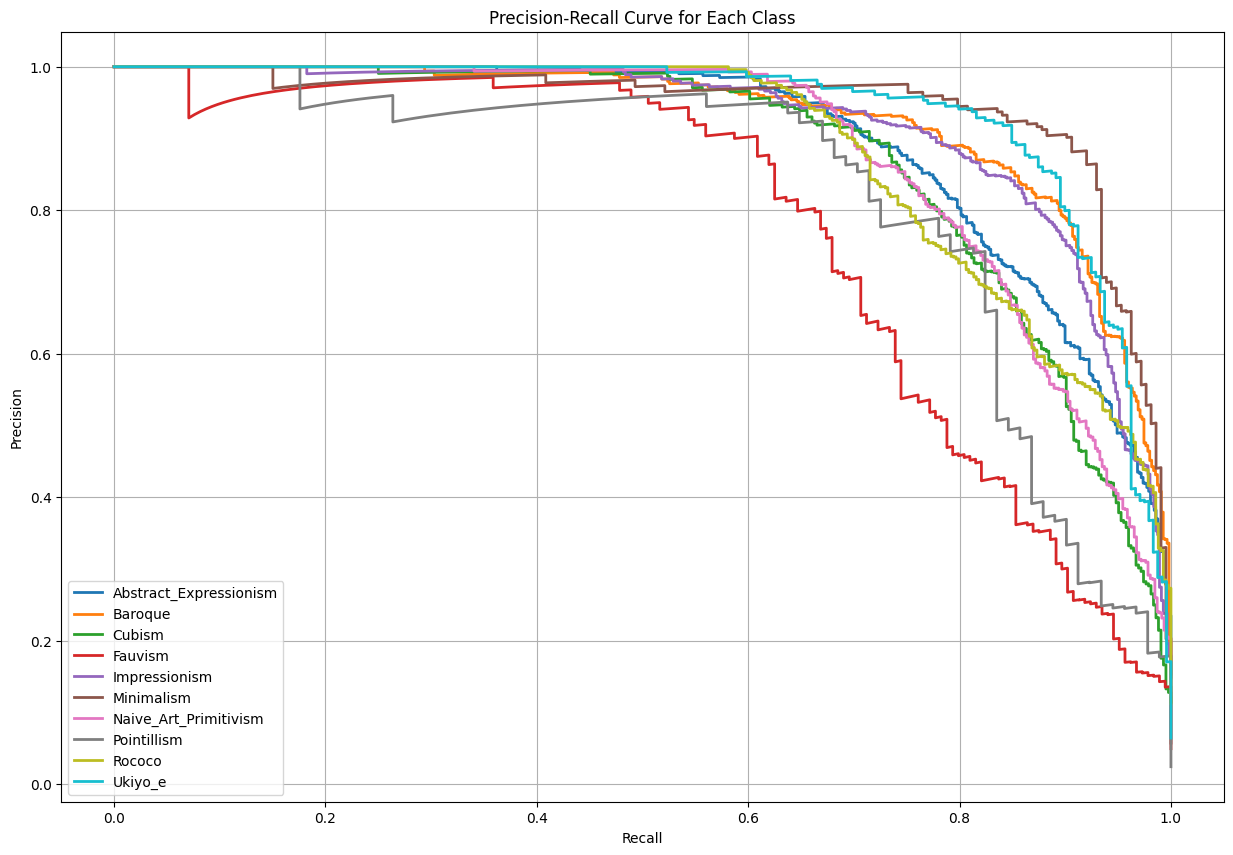

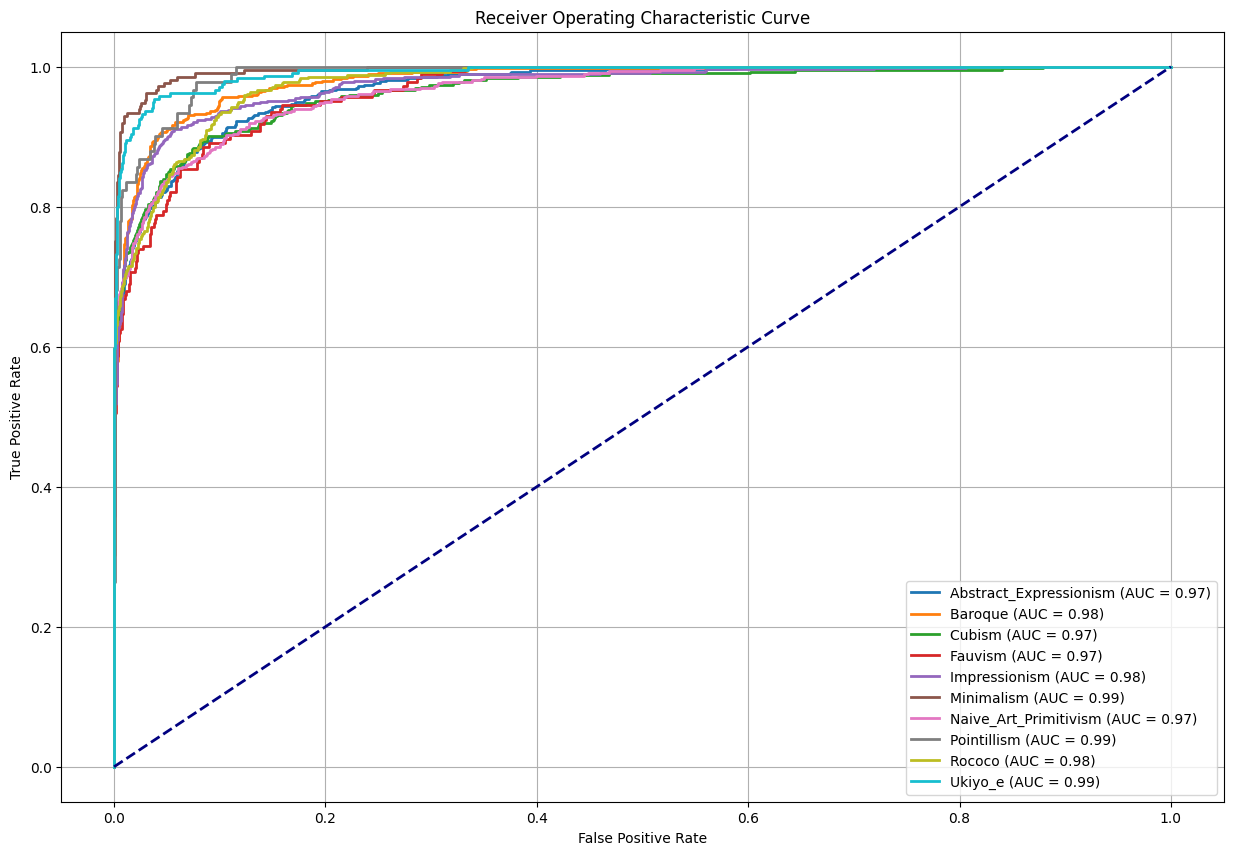

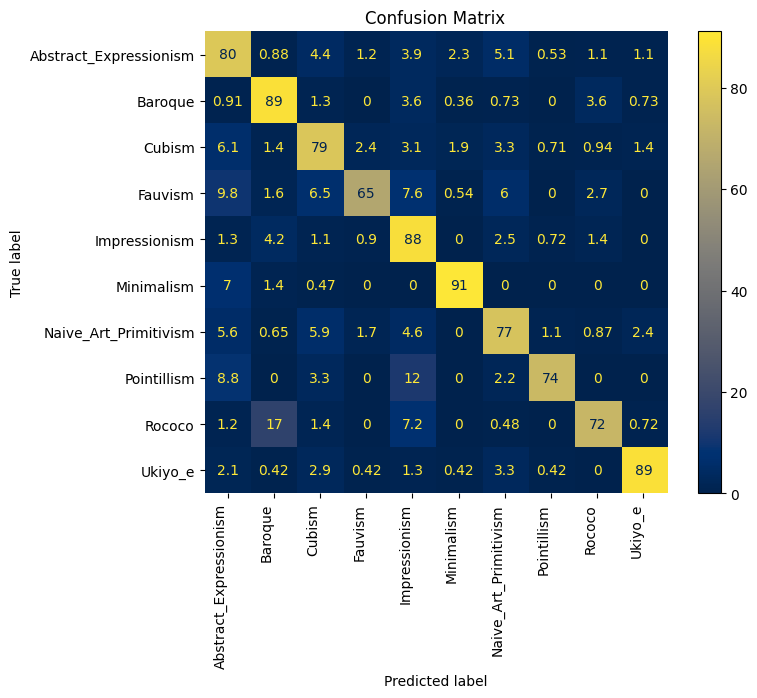

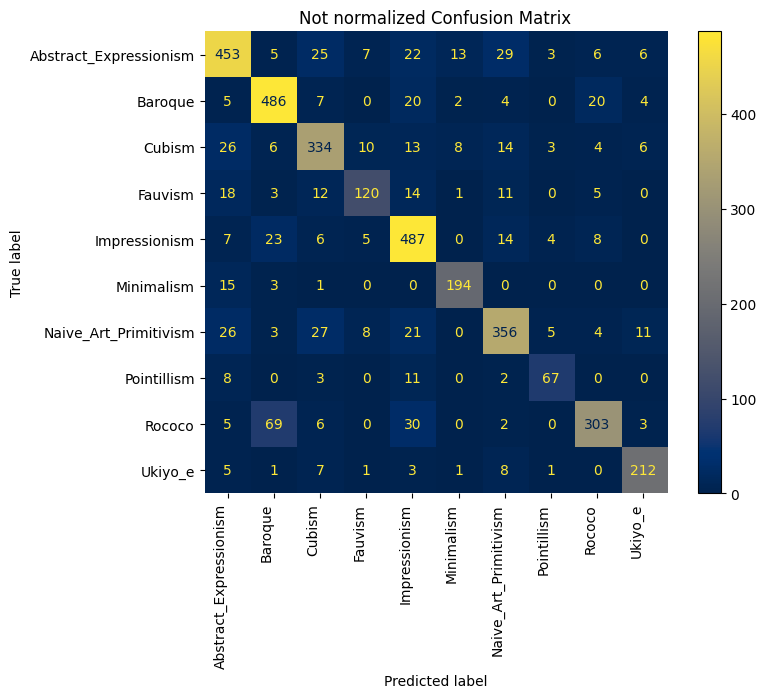

In [13]:
best_params = {
    'n_estimators': 1100,
    'max_depth': 46,
    'learning_rate':0.025099278542802222,
    'subsample': 0.7791580520863116,
    'colsample_bytree': 0.6832514547098782,
    'gamma': 0.23283876277794824,
    'reg_lambda': 0.32396552103512183,
    'reg_alpha': 0.8581323256446951
}

model = XGBClassifier(
    **best_params
)

model.fit(X_train_scaled, y_train)
frmodel_pred = model.predict(X_test_scaled)
frmodel_pred_proba = model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [14]:
best_params = {
    'n_estimators': 1100,
    'max_depth': 46,
    'learning_rate':0.025099278542802222,
    'subsample': 0.7791580520863116,
    'colsample_bytree': 0.6832514547098782,
    'gamma': 0.23283876277794824,
    'reg_lambda': 0.32396552103512183,
    'reg_alpha': 0.8581323256446951
}
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.810596  0.810592  0.809885  0.810592   91.573319   
1         2   0.810748  0.810051  0.809349  0.810051   93.444103   
2         3   0.805292  0.805188  0.804187  0.805188   92.379372   
3         4   0.812945  0.812483  0.811398  0.812483   94.138338   
4         5   0.810252  0.809511  0.808839  0.809511   93.635710   
5   Average   0.809967  0.809565  0.808732  0.809565   93.034168   
6  1.581139   0.002820  0.002691  0.002715  0.002691    1.038259   

   Prediction time  
0         0.028891  
1         0.028820  
2         0.028788  
3         0.028387  
4         0.028736  
5         0.028724  
6         0.000197  


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np
with open('X_mobilenet_v3_b15 (2).pickle', 'rb') as handle:
    train_data = pickle.load(handle)
with open('Y_mobilenet_v3_b15 (1).pickle', 'rb') as handle:
    train_labels = pickle.load(handle)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {np.shape(X_train)}, Test: {np.shape(X_test)}")
print(f"Train: {np.shape(train_data)}, Test: {np.shape(train_labels)}")

Train: (14804, 259), Test: (3701, 259)
Train: (18505, 259), Test: (18505,)


                        precision    recall  f1-score      support
Abstract_Expressionism   0.798165  0.765845  0.781671   568.000000
Baroque                  0.870036  0.804674  0.836080   599.000000
Cubism                   0.774947  0.823928  0.798687   443.000000
Fauvism                  0.655172  0.780822  0.712500   146.000000
Impressionism            0.869485  0.779242  0.821894   607.000000
Minimalism               0.857820  0.905000  0.880779   200.000000
Naive_Art_Primitivism    0.760776  0.820930  0.789709   430.000000
Pointillism              0.855556  0.895349  0.875000    86.000000
Rococo                   0.762836  0.840970  0.800000   371.000000
Ukiyo_e                  0.870293  0.828685  0.848980   251.000000
accuracy                 0.810592  0.810592  0.810592     0.810592
macro avg                0.807509  0.824545  0.814530  3701.000000
weighted avg             0.814638  0.810592  0.811243  3701.000000
--------------------------------------------------------------

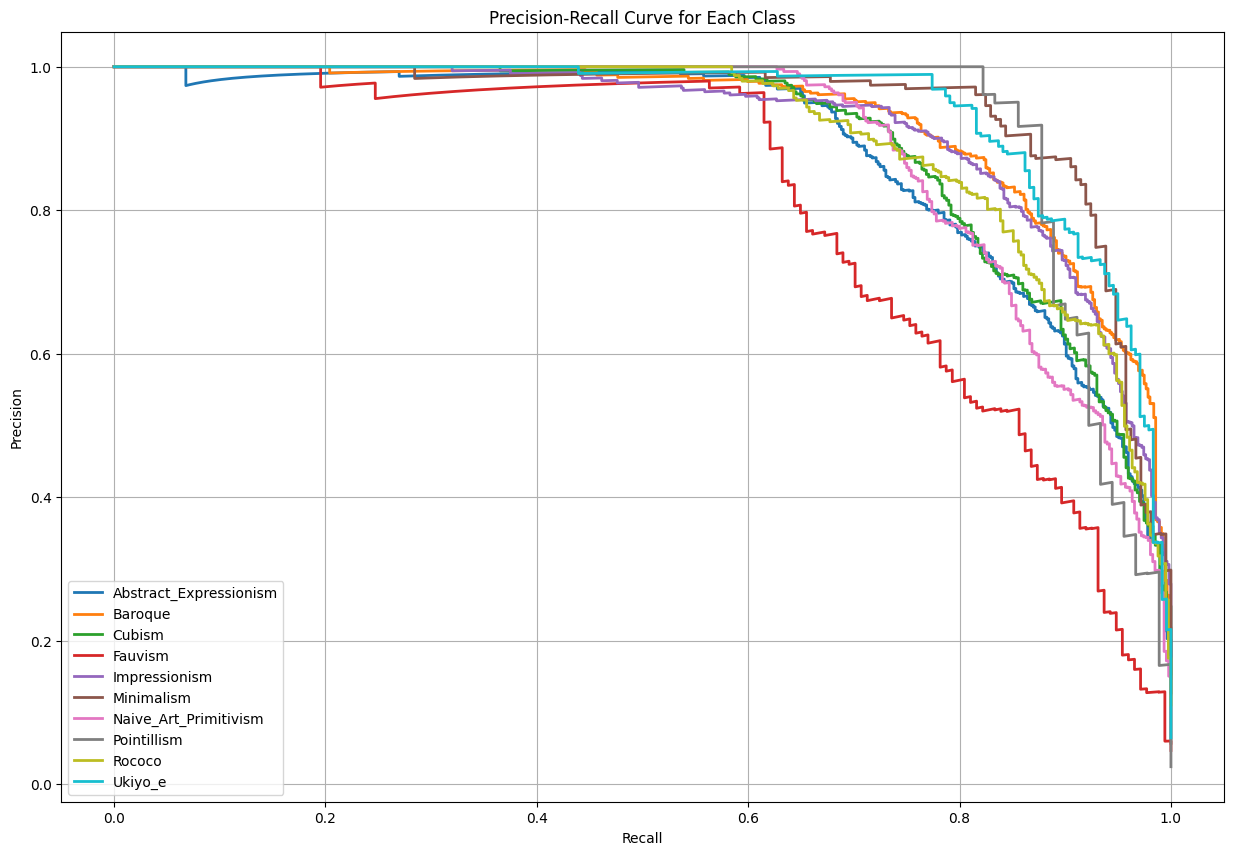

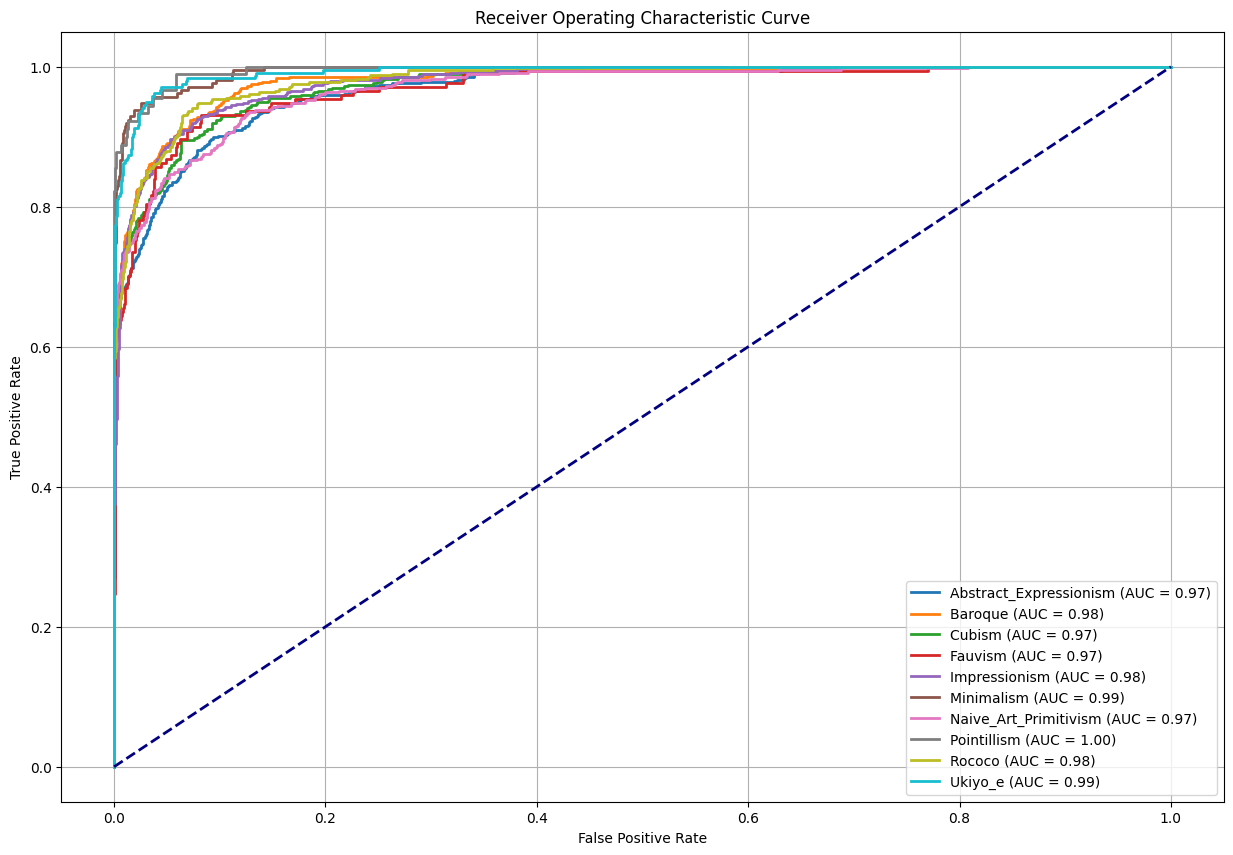

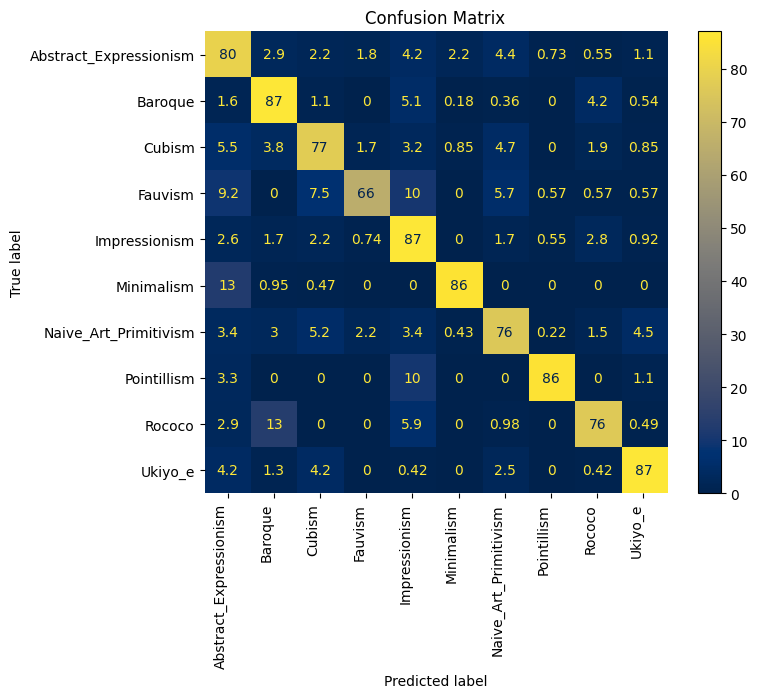

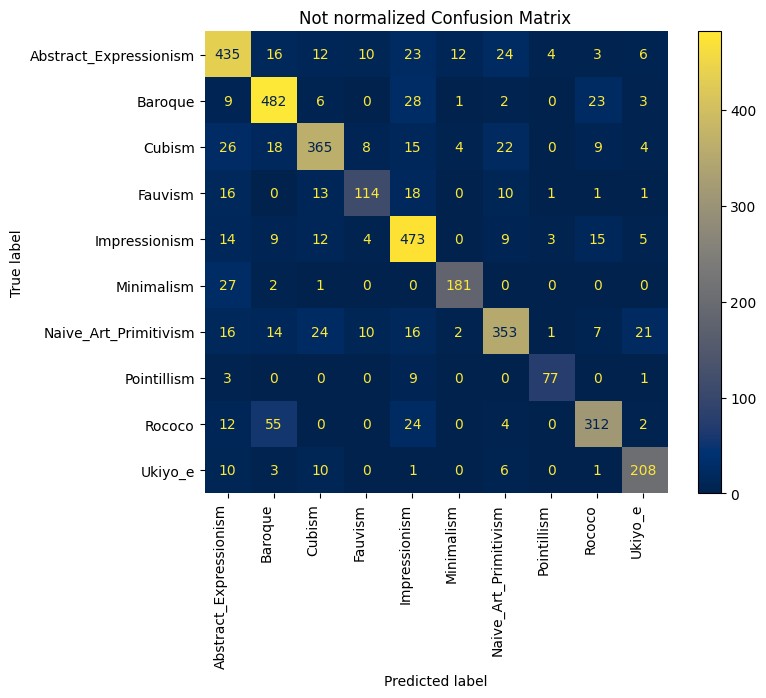

In [16]:
from xgboost import XGBClassifier

# Best parameters from tuning
best_params = {
    'n_estimators': 300,
    'max_depth': 34,
    'learning_rate': 0.03468816268140575,
    'subsample': 0.8485995040002692,
    'colsample_bytree': 0.8046060460485334,
    'gamma': 0.38000713487849,
    'reg_lambda': 0.26638117245916937,
    'reg_alpha': 0.1350800155935482
}

model = XGBClassifier(
    **best_params
)

model.fit(X_train_scaled, y_train)
frmodel_pred = model.predict(X_test_scaled)
frmodel_pred_proba = model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [17]:
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.805264  0.803567  0.802789  0.803567   47.419433   
1         2   0.818534  0.817617  0.816377  0.817617   47.351649   
2         3   0.806648  0.805728  0.804859  0.805728   47.552587   
3         4   0.799779  0.799784  0.798759  0.799784   47.507033   
4         5   0.810497  0.810322  0.808995  0.810322   47.465480   
5   Average   0.808144  0.807403  0.806356  0.807403   47.459236   
6  1.581139   0.006964  0.006863  0.006709  0.006863    0.077777   

   Prediction time  
0         0.014655  
1         0.014827  
2         0.014987  
3         0.014575  
4         0.014822  
5         0.014773  
6         0.000161  


/venv/main/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                        precision    recall  f1-score      support
Abstract_Expressionism   0.748624  0.769811  0.759070   530.000000
Baroque                  0.743682  0.800000  0.770814   515.000000
Cubism                   0.751592  0.776316  0.763754   456.000000
Fauvism                  0.655172  0.626374  0.640449   182.000000
Impressionism            0.806985  0.801095  0.804029   548.000000
Minimalism               0.857820  0.882927  0.870192   205.000000
Naive_Art_Primitivism    0.711207  0.665323  0.687500   496.000000
Pointillism              0.833333  0.833333  0.833333    90.000000
Rococo                   0.784841  0.726244  0.754407   442.000000
Ukiyo_e                  0.769874  0.776371  0.773109   237.000000
accuracy                 0.761416  0.761416  0.761416     0.761416
macro avg                0.766313  0.765779  0.765666  3701.000000
weighted avg             0.761128  0.761416  0.760816  3701.000000
--------------------------------------------------------------

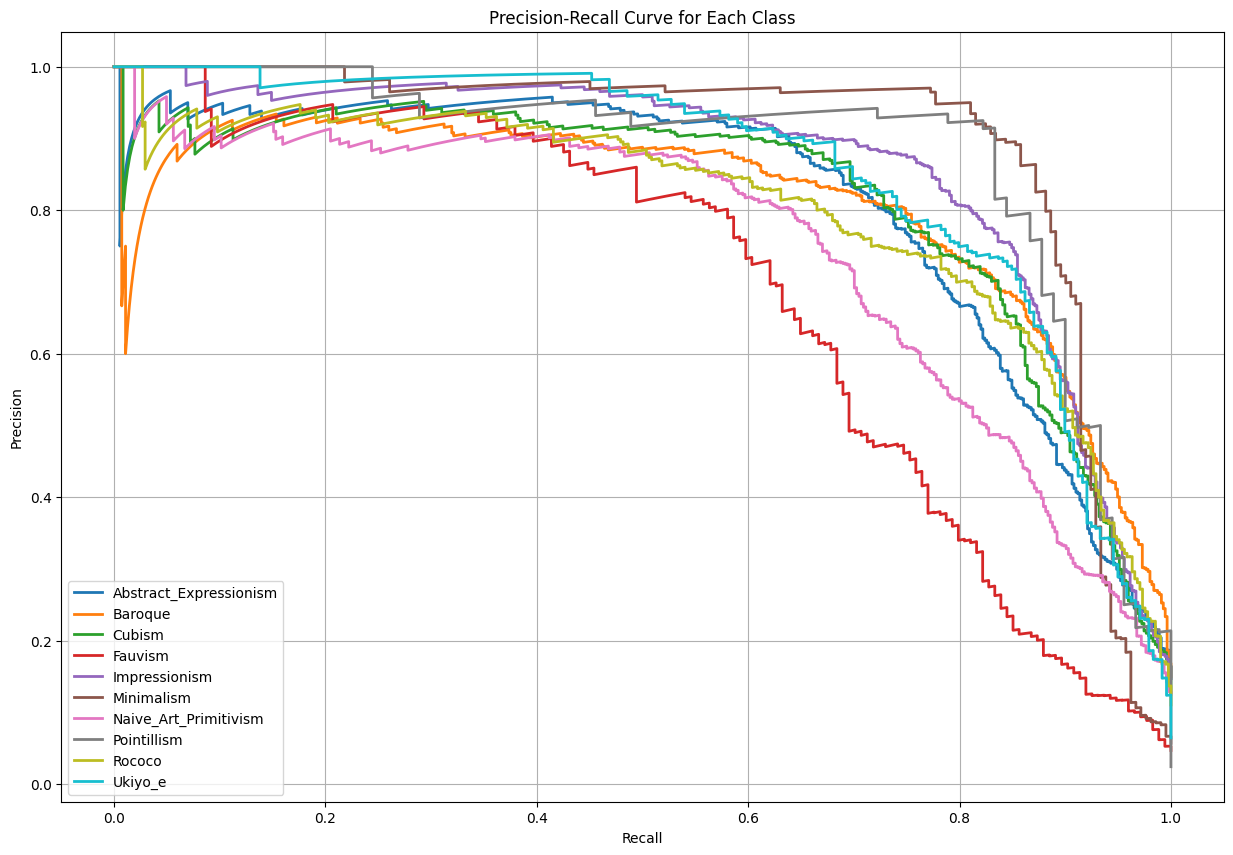

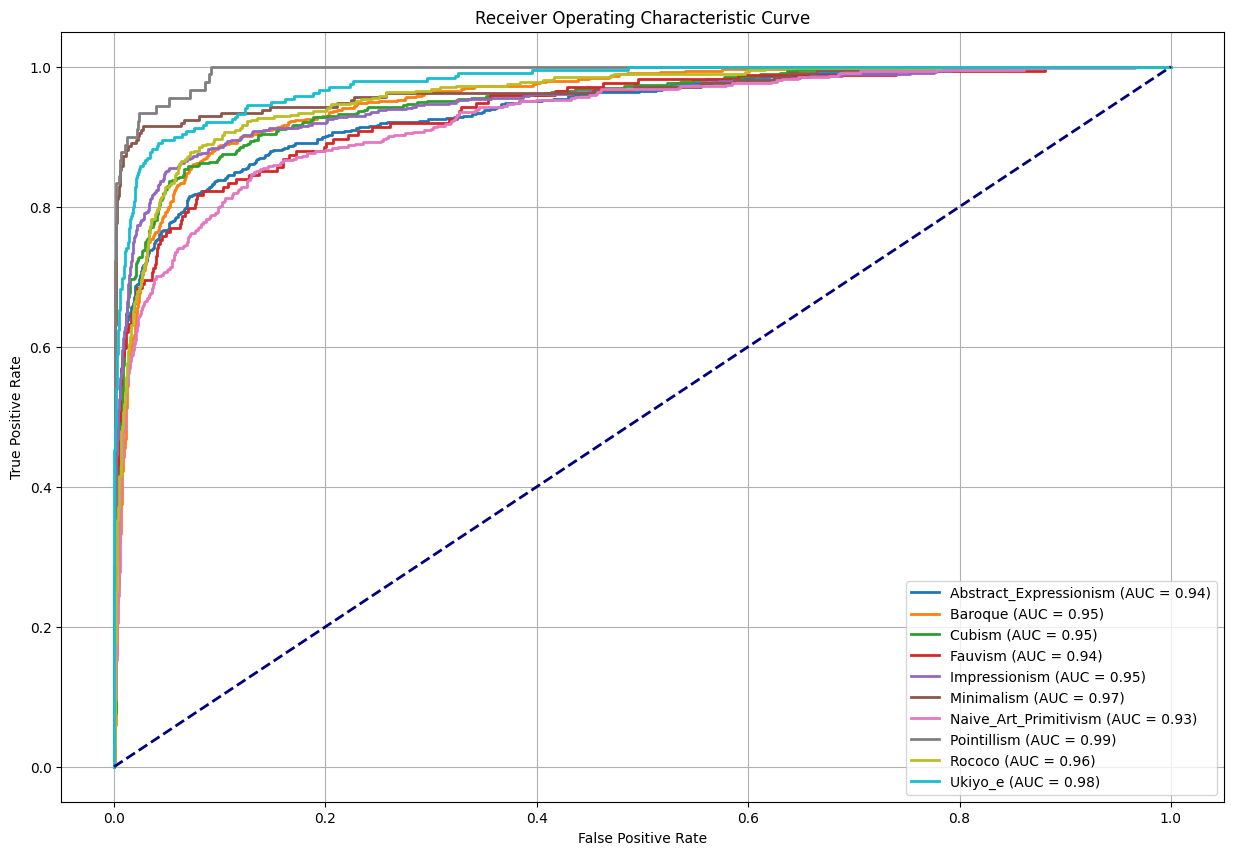

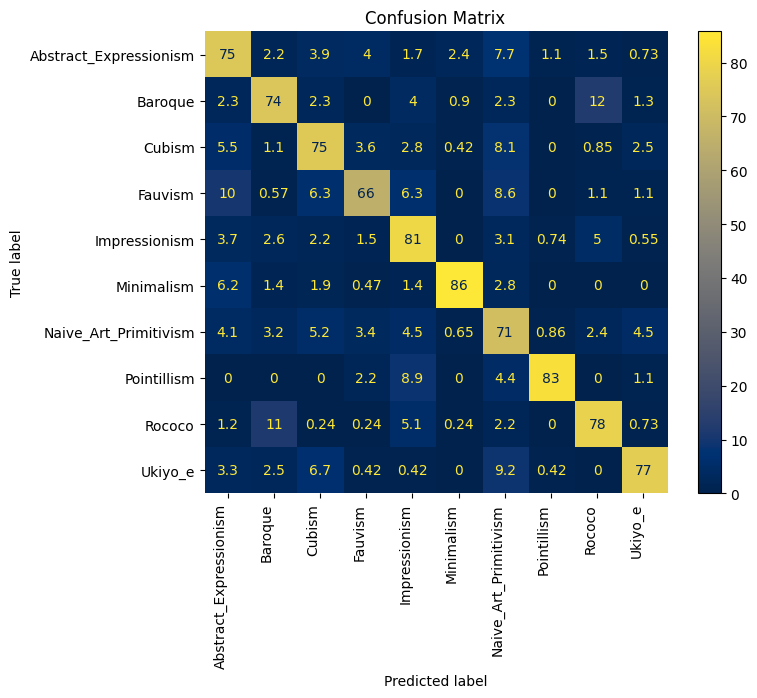

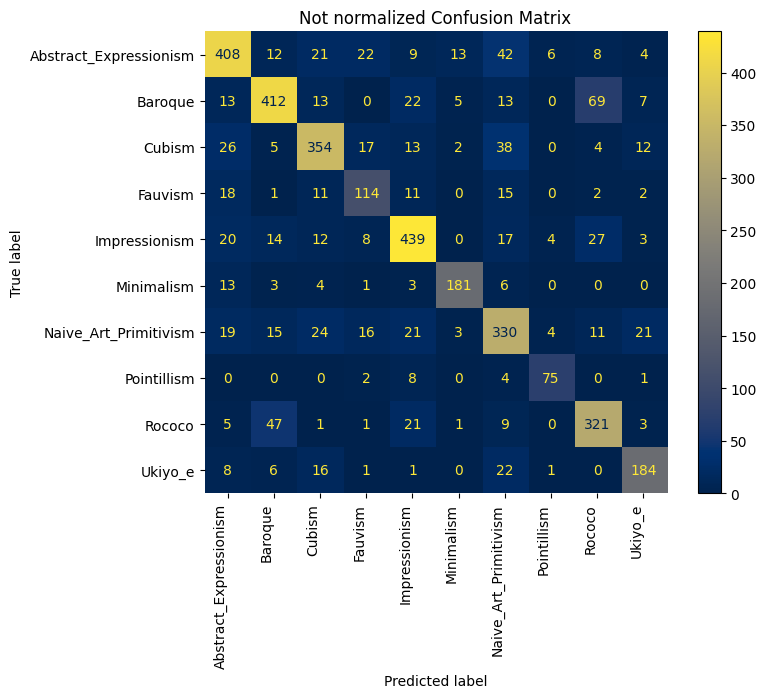

In [18]:
from sklearn.neural_network import MLPClassifier

best_params = {
    'hidden_layer_sizes': (450, 168, 128),
    'solver': 'adam',
    'learning_rate_init': 0.0021200237363646563,
    'alpha': 1.0454992501357614e-05,
    'batch_size': 64,
    'activation': 'logistic',
    'max_iter': 637
}
model = MLPClassifier(**best_params, random_state=42)
model.fit(X_train_scaled, y_train)
frmodel_pred = model.predict(X_test_scaled)
frmodel_pred_proba = model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)


In [19]:
best_params = {
    'hidden_layer_sizes': (450, 168, 128),
    'solver': 'adam',
    'learning_rate_init': 0.0021200237363646563,
    'alpha': 1.0454992501357614e-05,
    'batch_size': 64,
    'activation': 'logistic',
    'max_iter': 637
}
model = MLPClassifier(**best_params, random_state=42)
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.760967  0.758984  0.759163  0.758984   28.908755   
1         2   0.762467  0.760875  0.761418  0.760875   29.650059   
2         3   0.766310  0.764118  0.764655  0.764118   31.154737   
3         4   0.760445  0.758444  0.758717  0.758444   28.849788   
4         5   0.757646  0.757633  0.757131  0.757633   29.666335   
5   Average   0.761567  0.760011  0.760217  0.760011   29.645935   
6  1.581139   0.003174  0.002587  0.002917  0.002587    0.929274   

   Prediction time  
0         0.027377  
1         0.027735  
2         0.027415  
3         0.028213  
4         0.028695  
5         0.027887  
6         0.000562  


/venv/main/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                        precision    recall  f1-score      support
Abstract_Expressionism   0.739450  0.830928  0.782524   485.000000
Baroque                  0.814079  0.673134  0.736928   670.000000
Cubism                   0.749469  0.802273  0.774973   440.000000
Fauvism                  0.597701  0.904348  0.719723   115.000000
Impressionism            0.878676  0.648575  0.746292   737.000000
Minimalism               0.815166  0.934783  0.870886   184.000000
Naive_Art_Primitivism    0.713362  0.725877  0.719565   456.000000
Pointillism              0.788889  0.876543  0.830409    81.000000
Rococo                   0.682152  0.832836  0.750000   335.000000
Ukiyo_e                  0.686192  0.828283  0.750572   198.000000
accuracy                 0.758173  0.758173  0.758173     0.758173
macro avg                0.746514  0.805758  0.768187  3701.000000
weighted avg             0.771068  0.758173  0.757236  3701.000000
--------------------------------------------------------------

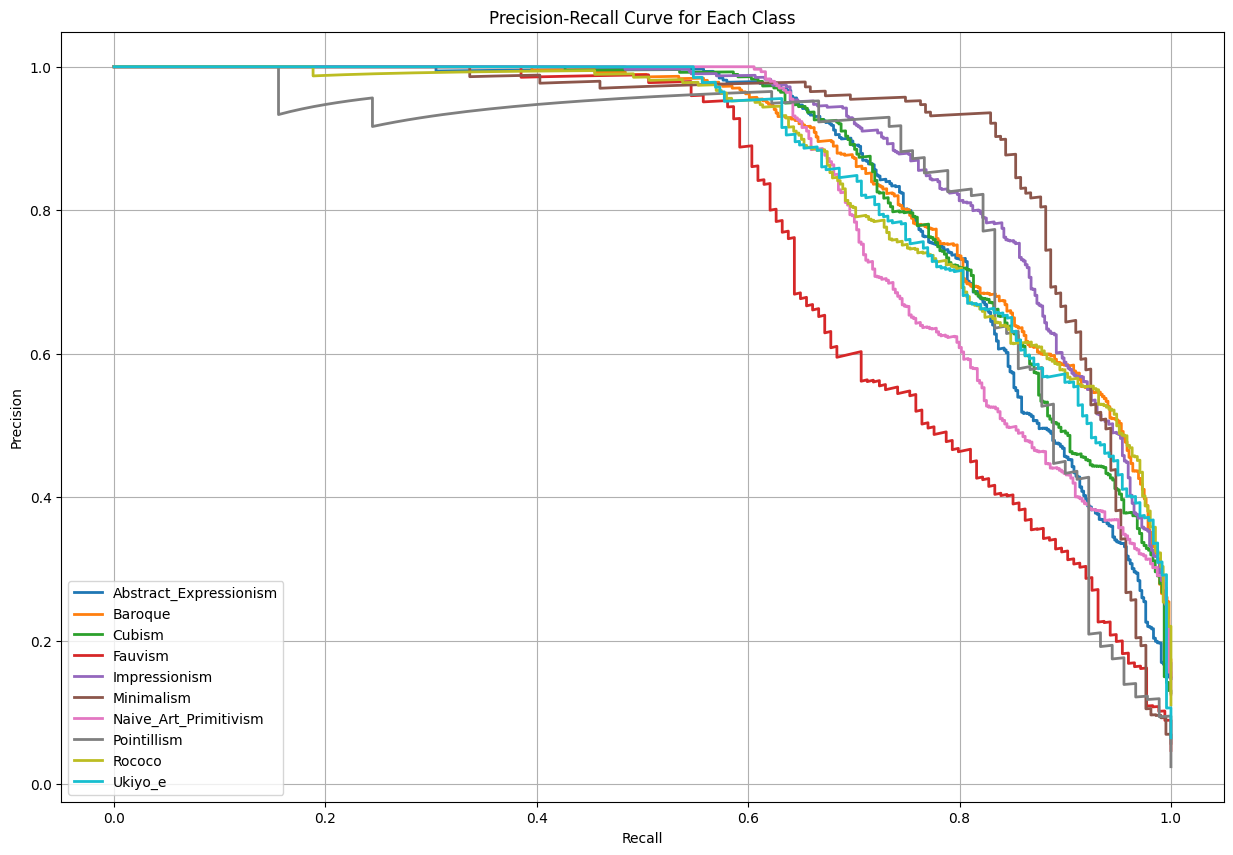

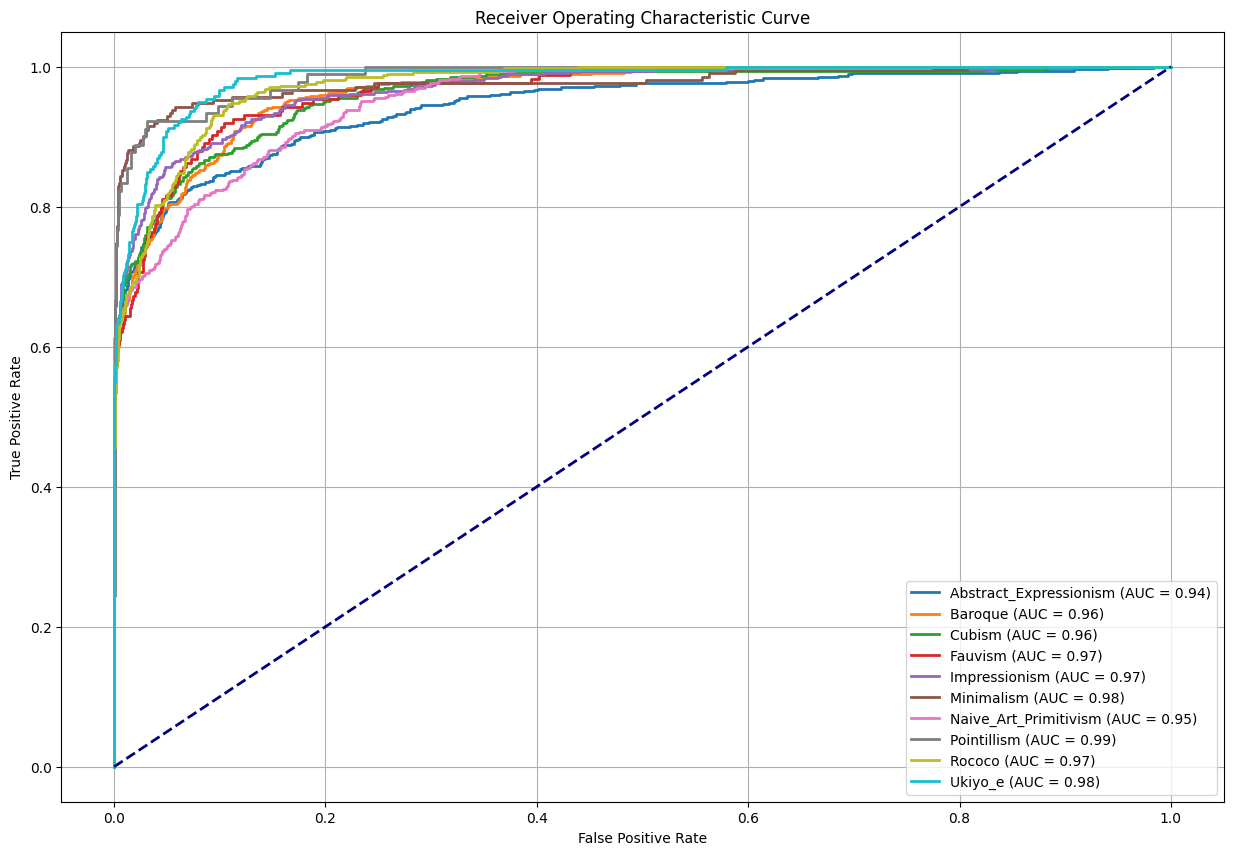

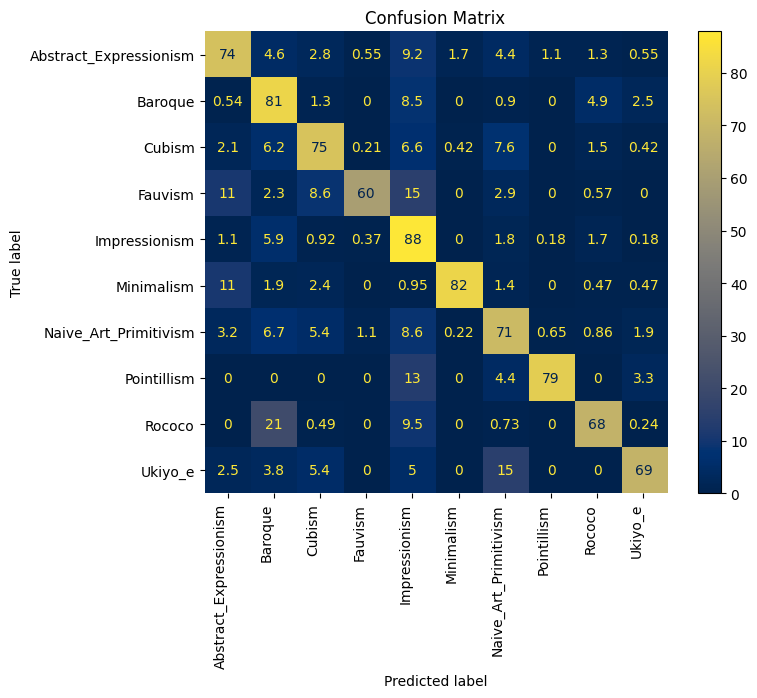

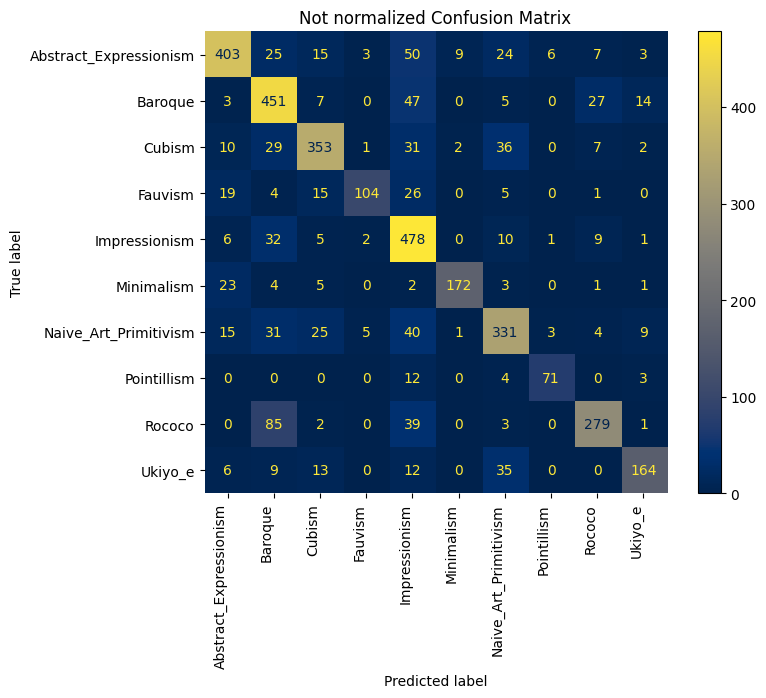

In [20]:
from sklearn.svm import SVC

svc_model = SVC(
    kernel='poly', 
    C=40.3350903958738, 
    gamma=2.3991851217134, 
    degree=3, 
    random_state=42,
    probability = True
)

svc_model.fit(X_train_scaled, y_train)
frmodel_pred = svc_model.predict(X_test_scaled)
frmodel_pred_proba = svc_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [21]:
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  svc_model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.766468  0.750608  0.750147  0.750608  136.498930   
1         2   0.777654  0.759254  0.759111  0.759254  137.787184   
2         3   0.775941  0.761146  0.761704  0.761146  161.060928   
3         4   0.765578  0.747095  0.747025  0.747095  155.937119   
4         5   0.786521  0.771954  0.771538  0.771954  138.688177   
5   Average   0.774433  0.758011  0.757905  0.758011  145.994467   
6  1.581139   0.008669  0.009743  0.009751  0.009743   11.584053   

   Prediction time  
0         3.774536  
1         2.943361  
2         3.019271  
3         2.793580  
4         2.817550  
5         3.069660  
6         0.404698  
